In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pandas import scatter_matrix
from collections import defaultdict
#from geopy.geocoders import Nominatim
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import src.airbnb_EDA_helper as eda
import src.airbnb_prediction_helper as pred

import cPickle as pickle

/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/johnkim/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [114]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import clone

import statsmodels.api as sm
#from scipy.misc import imread

#import gmplot

#import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)

## Load Data

In [5]:
monthly_data_raw_df = pd.read_excel('data/Loftium/Back testing - Copy.xlsx', sheetname='Monthly')
listing_data_raw_df = pd.read_excel('data/Loftium/Back testing - Copy.xlsx', sheetname='Listings')

In [6]:
monthly_data_raw_df.columns = monthly_data_raw_df.columns.str.replace(' ','_')
listing_data_raw_df.columns = listing_data_raw_df.columns.str.replace(' ','_').str.replace('\(','').str.replace('\)','').str.replace('-','')  

## Cleaning Data

In [7]:
listing_data_df = listing_data_raw_df.copy()

In [8]:
listing_data_df.Listing_Title = listing_data_raw_df.Listing_Title.str.lower()

In [9]:
listing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 46 columns):
Property_ID                      1936 non-null int64
Host_ID                          1935 non-null float64
Listing_Title                    1936 non-null object
Property_Type                    1936 non-null object
Listing_Type                     1936 non-null object
Created_Date                     1936 non-null datetime64[ns]
Last_Scraped_Date                1936 non-null datetime64[ns]
Country                          1936 non-null object
State                            1936 non-null object
City                             1936 non-null object
Neighborhood                     1727 non-null object
Metropolitan_Statistical_Area    1936 non-null object
Zipcode                          1936 non-null int64
Average_Daily_Rate               1936 non-null float64
Annual_Revenue_LTM               1936 non-null int64
Occupancy_Rate_LTM               1936 non-null float64
Occupancy_Cal

In [10]:
null_cols = eda.check_for_null(listing_data_df)

***WARNING*** : 1 null values in Host_ID
***WARNING*** : 209 null values in Neighborhood
***WARNING*** : 157 null values in Overall_Rating
***WARNING*** : 5 null values in Bathrooms
***WARNING*** : 4 null values in Calendar_Last_Updated
***WARNING*** : 299 null values in Response_Rate
***WARNING*** : 300 null values in Response_Time_min
***WARNING*** : 241 null values in Superhost
***WARNING*** : 1218 null values in Security_Deposit
***WARNING*** : 614 null values in Cleaning_Fee
***WARNING*** : 1062 null values in Extra_People_Fee
***WARNING*** : 3 null values in Published_Monthly_Rate
***WARNING*** : 4 null values in Published_Weekly_Rate
***WARNING*** : 650 null values in Checkin_Time
***WARNING*** : 636 null values in Checkout_Time


In [11]:
listing_data_df = eda.impute_null_columns(listing_data_df)

In [12]:
eda.check_for_null(listing_data_df)

[]

In [13]:
# Adding flags for views, water, priv bathrooms, parking
listing_data_df['view'] = listing_data_df.Listing_Title.str.contains(' view').astype(int)
water_pattern = r'(( water|^water|saltwater| lake|^lake|greenlake| bay|^bay).*(view))|(view).*( water|^water|saltwater| lake|^lake|greenlake| bay|^bay)'
listing_data_df['water'] = listing_data_df.Listing_Title.str.contains(water_pattern).astype(int)
listing_data_df['private_bath'] = listing_data_df.Listing_Title.str.contains('bath').astype(int)
listing_data_df['walk'] = (listing_data_df.Listing_Title.str.contains('walk')).astype(int)
listing_data_df['parking'] = (listing_data_df.Listing_Title.str.contains('parking')).astype(int)

# Adding flags for nonrooms
nonroom_pattern = r'((couch|futon|space))'
listing_data_df['nonroom'] = ((listing_data_df.Listing_Title.str.contains(nonroom_pattern)) & \
                          ~(listing_data_df.Listing_Title.str.contains('needle'))).astype(int)

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [14]:
# Converting Created_Date to Days_Since_Created
listing_data_df['Days_Since_Created'] = listing_data_df.Created_Date.apply(lambda x: (listing_data_df.Created_Date.max()-x).days)

In [15]:
listing_data_df['EDR'] = listing_data_df.Occupancy_Calculated * listing_data_df.Average_Daily_Rate

In [16]:
listing_data_df.shape

(1936, 54)

Let's remove any "non-relevant" data points

In [17]:
listing_data_df = listing_data_df[listing_data_df.Number_of_Bookings_LTM > 4]

In [18]:
listing_data_df = listing_data_df[listing_data_df.Occupancy_Calculated > .5]

In [19]:
listing_data_df.shape

(920, 54)

## EDA

In [20]:
# latitudes = listing_data_df.Latitude.values
# longitudes = listing_data_df.Longitude.values

In [21]:
# gmap = gmplot.GoogleMapPlotter(47.628, -122.35, 13)

In [22]:
# #gmap.scatter(latitudes, longitudes, 'cornflowerblue', edge_width=10)
# gmap.heatmap(latitudes, longitudes)
# gmap.draw("mymap.html")

In [23]:
# !pwd

`file://Users/johnkim/Google_Drive/Galvanize/Capstone/Airbnb/mymap.html`

In [24]:
listing_data_df.Property_Type.unique()

array([u'Apartment', u'Loft', u'House', u'Bed & Breakfast', u'Other',
       u'Condominium', u'Townhouse', u'Bungalow', u'Cabin', u'Camper/RV',
       u'Entire Floor', u'Bed &amp; Breakfast'], dtype=object)

In [25]:
listing_data_df['Property_Type'].replace('Bed &amp; Breakfast', 'Bed & Breakfast', inplace=True)

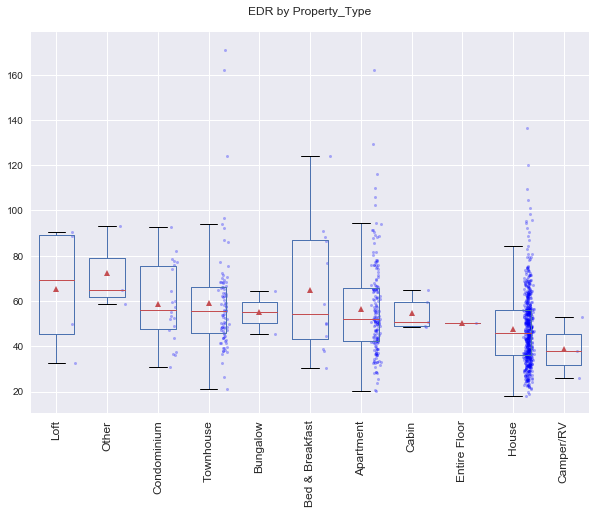

In [26]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Property_Type',column='EDR', 
                       rot=90, fontsize=12, figsize=(10,7), jitter_offset=0.3)
plt.show()

**Takeaways:**
- Townhouses command higher EDRs than houses, possibly due to their proximity to areas of interest, such as city centers, tourist attractions, etc In contrast, houses are locationed in suburban areas. 
- **Property type is likely correlated with location. Including in a linear model may lead to collinearity issues.**

In [27]:
listing_data_df.Property_Type.value_counts()

House              610
Apartment          172
Townhouse           86
Condominium         22
Bed & Breakfast     12
Cabin                5
Loft                 4
Camper/RV            3
Other                3
Bungalow             2
Entire Floor         1
Name: Property_Type, dtype: int64

In [28]:
# Only keeping relevant property types
features_Property_type_keep = ['House', 'Apartment','Townhouse','Condominium', 'Bed & Breakfast','Loft','Other']
listing_data_df = listing_data_df[listing_data_df.Property_Type.isin(features_Property_type_keep)]

In [29]:
listing_data_df.shape

(909, 54)

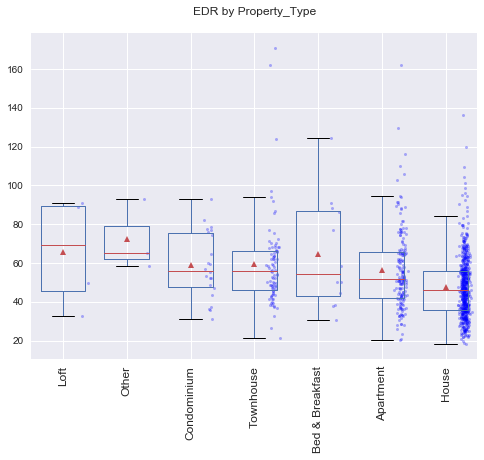

In [30]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Property_Type',column='EDR', 
                       rot=90, fontsize=12, figsize=(8,6), jitter_offset=0.3, show_outliers=True)

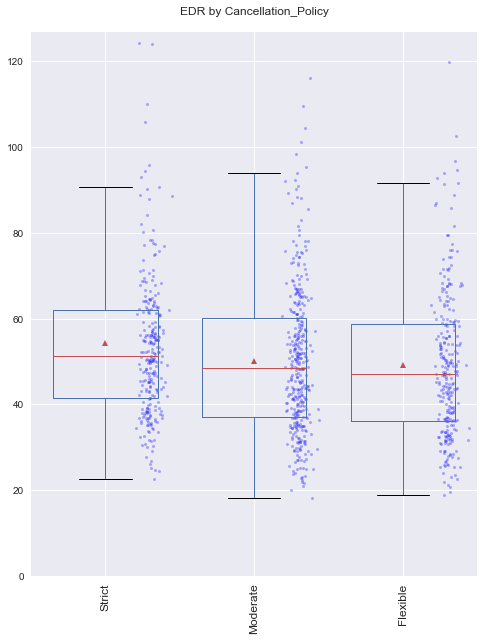

In [31]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Cancellation_Policy',column='EDR', 
                       rot=90, fontsize=12, figsize=(8,10), jitter_offset=0.3, show_outliers=False)

In [32]:
listing_data_df.Zipcode.unique()

array([98101, 98144, 98109, 98104, 98122, 98112, 98102, 98103, 98117,
       98105, 98107, 98116, 98108, 98119, 98115, 98146, 98118, 98136,
       98199, 98188, 98178, 98126, 98106, 98177, 98125, 98121, 98198,
       98155, 98168, 98166, 98133, 98148, 98134])

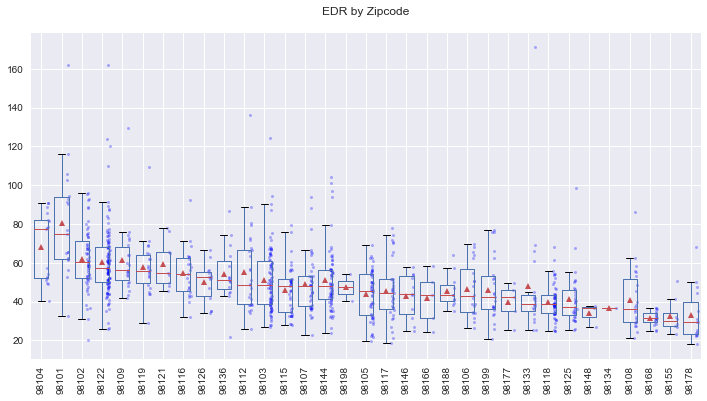

In [33]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Zipcode', column='EDR', 
                       rot=90, fontsize=10, jitter_offset=0.3, show_outliers=True)
plt.show()

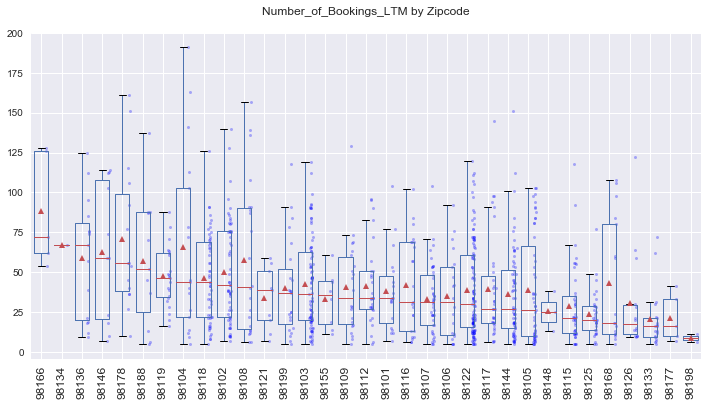

In [34]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Zipcode', column='Number_of_Bookings_LTM', 
                       rot=90, fontsize=12, jitter_offset=0.3, show_outliers=True)
plt.show()

**Takeaways:**
- Some variation is explained by zipcode
- However, suprising amount of variation per zipcode

In [35]:
temp_df = listing_data_df.groupby('Neighborhood').count()['Property_ID'].sort_values(ascending=False)

In [36]:
temp_df = temp_df[temp_df > 10]

In [37]:
temp_df = listing_data_df[listing_data_df.Neighborhood.isin(temp_df.index)]

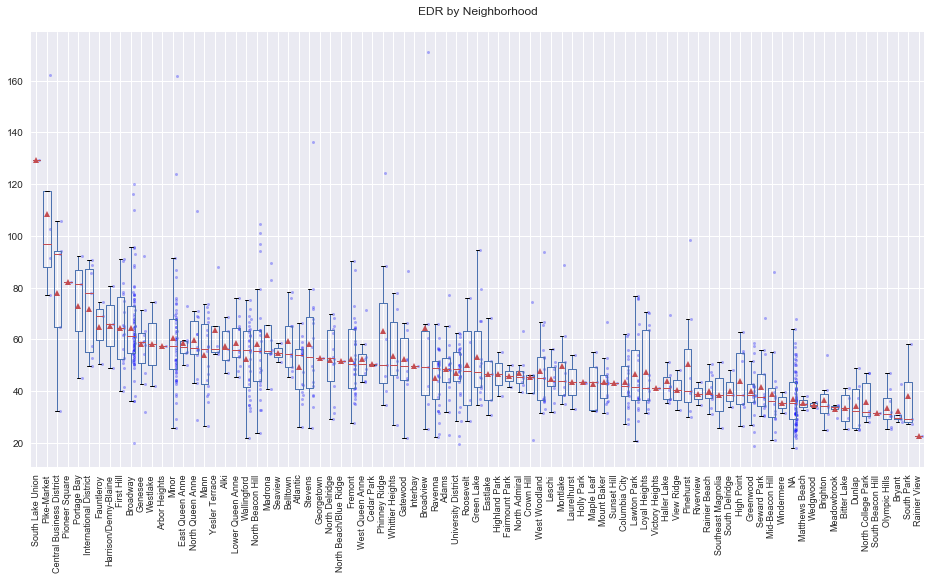

In [38]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Neighborhood', column='EDR', 
                       rot=90, fontsize=9, jitter_offset=0.3, figsize=(16,8), show_outliers=True)
plt.show()

In [39]:
listing_data_df[listing_data_df.Neighborhood=='Pike-Market']

,Property_ID,Host_ID,Listing_Title,Property_Type,Listing_Type,Created_Date,Last_Scraped_Date,Country,State,City,Neighborhood,Metropolitan_Statistical_Area,Zipcode,Average_Daily_Rate,Annual_Revenue_LTM,Occupancy_Rate_LTM,Occupancy_Calculated,Number_of_Bookings_LTM,Number_of_Reviews,Overall_Rating,Bedrooms,Bathrooms,Max_Guests,Calendar_Last_Updated,Response_Rate,Response_Time_min,Superhost,Cancellation_Policy,Security_Deposit,Cleaning_Fee,Extra_People_Fee,Published_Nightly_Rate,Published_Monthly_Rate,Published_Weekly_Rate,Checkin_Time,Checkout_Time,Minimum_Stay,Count_Reservation_Days_LTM,Count_Available_Days_LTM,Count_Blocked_Days_LTM,Number_of_Photos,Instantbook_Enabled,Listing_URL,Listing_Main_Image_URL,Latitude,Longitude,view,water,private_bath,walk,parking,nonroom,Days_Since_Created,EDR
0,7451624,8.55463e+06,private room in luxury dt tower,Apartment,Private room,2015-07-18,2016-02-07,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,245.97,35174,0.659,0.658986,53,33,5.0,1,1.0,2,2016-02-01,92.000000,0.050000,0.0,Strict,0.0,25.0,0.0,168,4704.0,1176.0,16:00:00,11:00:00,1,143,74,149,37,1,https://www.airbnb.com/rooms/7451624,https://a0.muscache.com/im/pictures/105611228/...,47.608447,-122.341485,0,0,0,0,0,0,390,162.090829
20,5415077,2.65472e+07,spacious room in pike place market!,Condominium,Private room,2015-02-19,2016-10-05,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,143.04,25890,0.539,0.538690,51,62,4.8,1,2.0,2,2016-09-14,92.000000,466.180000,1.0,Strict,0.0,30.0,0.0,160,3640.0,910.0,Anytime after 3PM,11:00:00,2,181,155,30,16,0,https://www.airbnb.com/rooms/5415077,https://a1.muscache.com/im/pictures/69722130/8...,47.609798,-122.340368,0,0,0,0,0,0,539,77.054286
202,11938847,2.3467e+07,super rad pad!,Apartment,Private room,2016-03-18,2016-10-04,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,126.23,15653,0.867,0.725146,44,27,4.9,1,1.0,2,2016-10-04,100.000000,164.320000,0.0,Flexible,0.0,0.0,20.0,100,2800.0,700.0,NA,NA,2,124,47,13,4,0,https://www.airbnb.com/rooms/11938847,https://a2.muscache.com/im/pictures/900481ae-f...,47.609447,-122.341567,0,0,0,0,0,0,146,91.535205
1415,14204510,3.89421e+07,private room at waterfront,Apartment,Private room,2016-07-26,2016-10-05,United States,Washington,Seattle,Pike-Market,"Seattle-Tacoma-Bellevue, WA Metro Area",98101,138.82,2360,0.850,0.739130,7,3,4.7,1,1.0,2,2016-09-26,95.585828,168.180165,0.0,Flexible,150.0,40.0,0.0,190,4200.0,1050.0,8AM - 11PM,18:00:00,1,17,6,39,8,0,https://www.airbnb.com/rooms/14204510,https://a2.muscache.com/im/pictures/a88dbbbb-7...,47.609689,-122.345059,0,0,0,0,0,0,16,102.606087


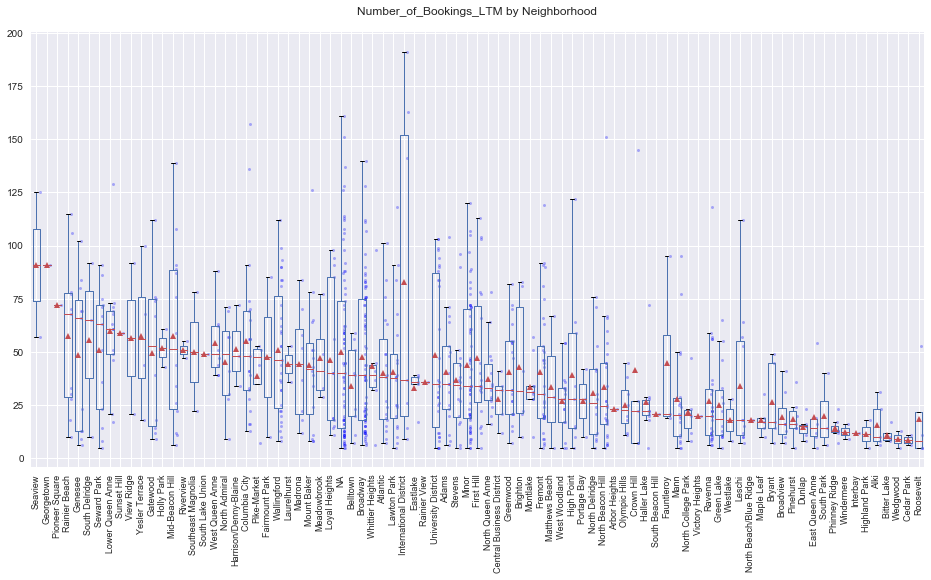

In [40]:
eda.plot_boxplot_sorted(listing_data_df, 
                       by='Neighborhood', column='Number_of_Bookings_LTM', 
                       rot=90, fontsize=9, jitter_offset=0.3, figsize=(16,8), show_outliers=True)
plt.show()

**Takeaways:**
- As one would expect, properties in the Pike-Market neighborhood command higher EDRs, but the sample is small. 
- There is still a surprising amount of variation in EDR per neighborhood. 

In [41]:
# Given Pike-Market's clear impact on EDR, include as a flag
listing_data_df['Pike_Market'] = (listing_data_df.Neighborhood=='Pike-Market').astype(int)

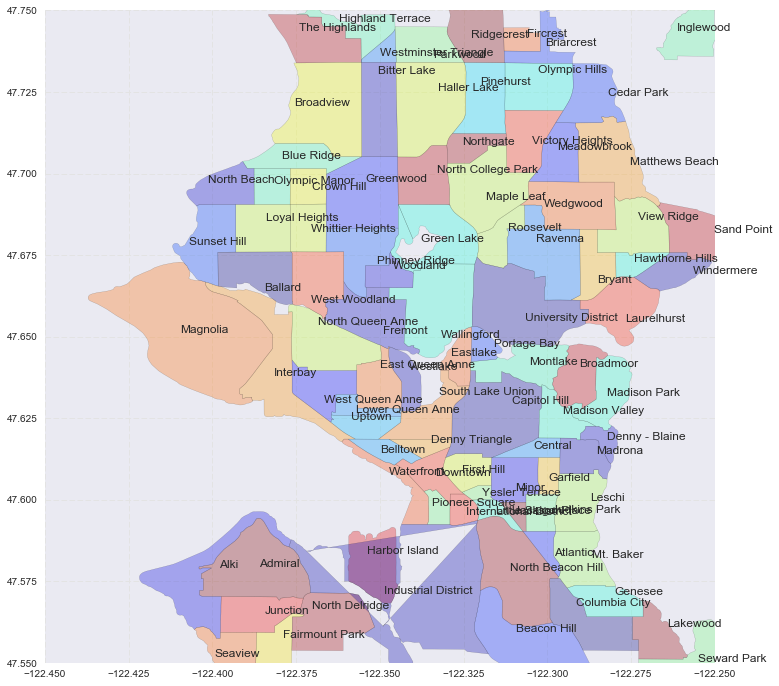

In [42]:
shapesfile = 'data/Zillow/ZillowNeighborhoods-WA/ZillowNeighborhoods-WA.shp'
eda.plot_neighborhoods(-122.45, -122.25, 47.55, 47.75, shapesfile, figsize=(12,12))

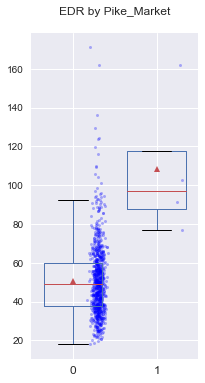

In [43]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Pike_Market', column='EDR', 
                        sort_flag=False,
                        rot=0, figsize=(3,6), fontsize=12, jitter_offset=0.3, show_outliers=True)

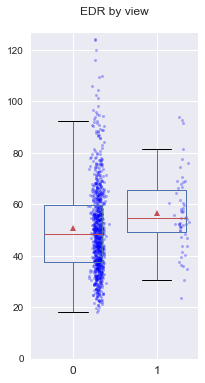

In [44]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='view', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

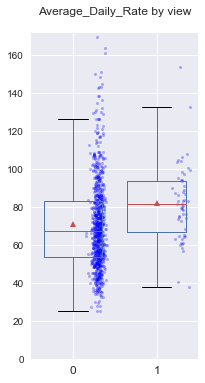

In [45]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='view', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

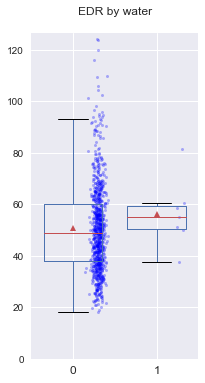

In [46]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='water', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a "water view" have **surprisingly** lower EDR

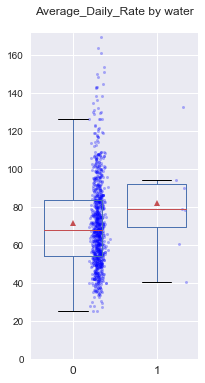

In [47]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='water', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a "view" have higher median and average ADRs

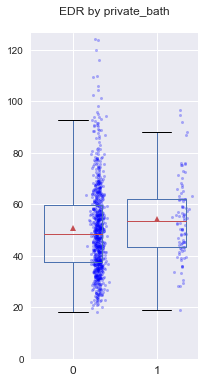

In [48]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='private_bath', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with a private bathrooms have higher median and average EDRs

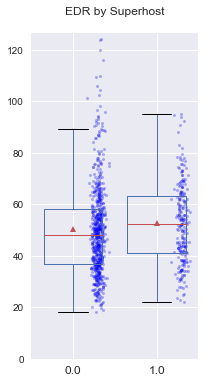

In [49]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Superhost', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)
plt.show()

**Takeaways:**
- Properties with Superhosts have higher median and average EDRs

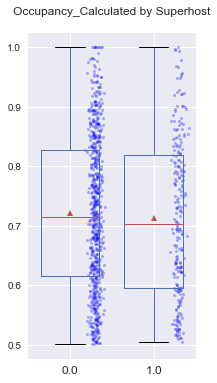

In [50]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Superhost', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=True)
plt.show()

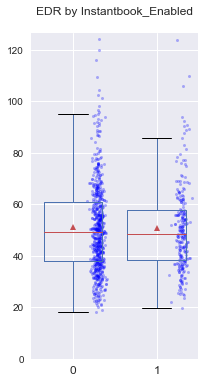

In [51]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Instantbook_Enabled', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

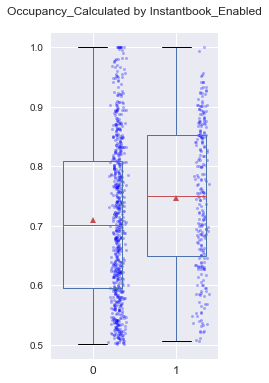

In [52]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='Instantbook_Enabled', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=True)

**Takeaways:**
- Properties with Instabook_Enabled have higher median and average EDRs

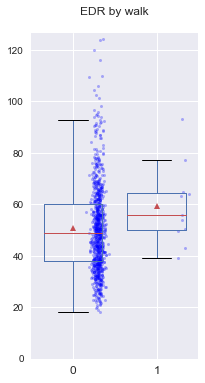

In [53]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

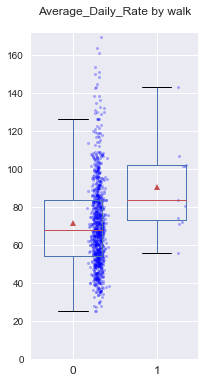

In [54]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='Average_Daily_Rate', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,6), jitter_offset=0.3, show_outliers=False)

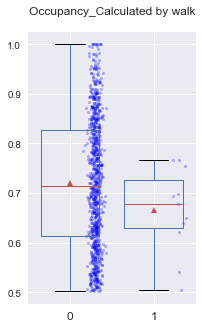

In [55]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='walk', column='Occupancy_Calculated', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,5), jitter_offset=0.3, show_outliers=True)

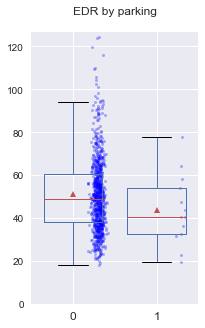

In [56]:
eda.plot_boxplot_sorted(listing_data_df, 
                        by='parking', column='EDR', 
                        sort_flag=False,
                        rot=0, fontsize=12, figsize=(3,5), jitter_offset=0.3, show_outliers=False)

(0, 200)

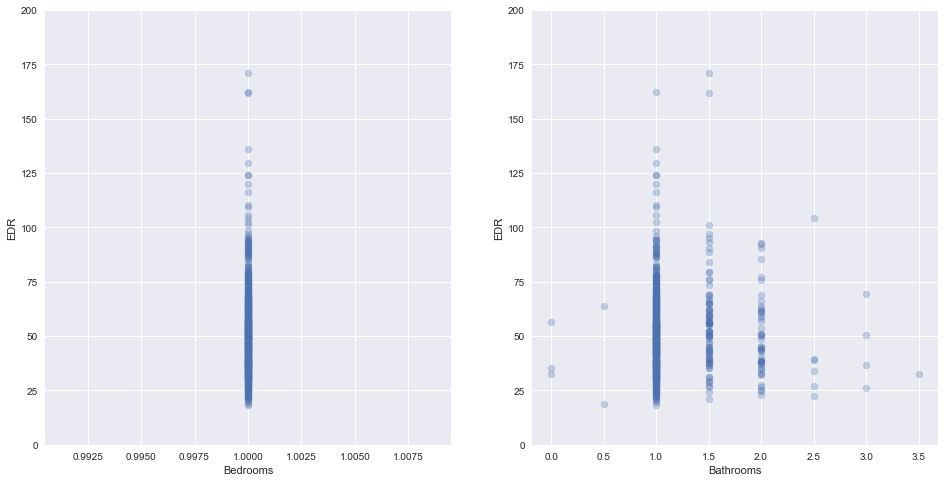

In [57]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Bedrooms'], listing_data_df['EDR'], alpha=0.3)
ax[0].set_xlabel('Bedrooms')
ax[0].set_ylabel('EDR')
ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Bathrooms'], listing_data_df['EDR'], alpha=0.3)
ax[1].set_xlabel('Bathrooms')
ax[1].set_ylabel('EDR')
#ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(0,200)

### How do User Reviews affect EDR?

(0, 200)

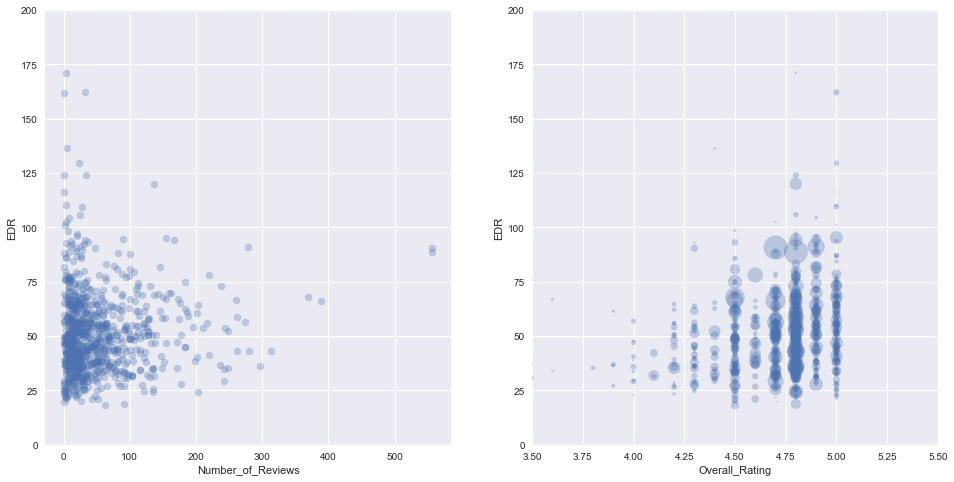

In [58]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Number_of_Reviews'], listing_data_df['EDR'], alpha=0.3)
ax[0].set_xlabel('Number_of_Reviews')
ax[0].set_ylabel('EDR')
ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Overall_Rating'], listing_data_df['EDR'], 
              alpha=0.3, s=listing_data_df['Number_of_Reviews'])
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('EDR')
ax[1].set_xlim(3.5,5.5)
ax[1].set_ylim(0,200)

There are long tails on both x and y axes, so let's try a log transform.

/Users/johnkim/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


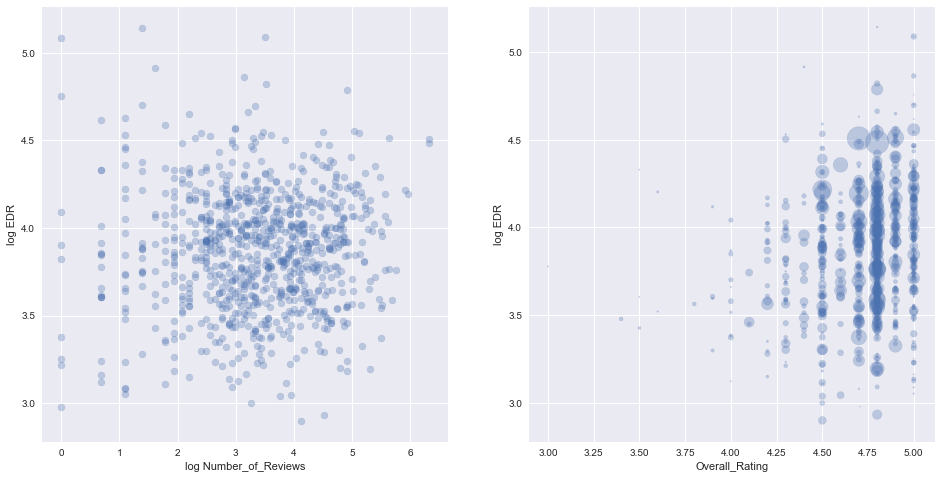

In [59]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(np.log(listing_data_df['Number_of_Reviews']), np.log(listing_data_df['EDR']), alpha=0.3)
ax[0].set_xlabel('log Number_of_Reviews')
ax[0].set_ylabel('log EDR')
# ax[0].set_ylim(0,200)
ax[1].scatter(listing_data_df['Overall_Rating'], np.log(listing_data_df['EDR']), 
              alpha=0.3, s=listing_data_df['Number_of_Reviews'])
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('log EDR')
# ax[1].set_xlim(3.5,5.5)
# ax[1].set_ylim(0,200)

**Takeaways:**
- As expected, as Number_of_Reviews increases, the EDR tends to increase
- As expected, as Overall_Rating increases, the EDR tends to increase

(3.2, 5.2)

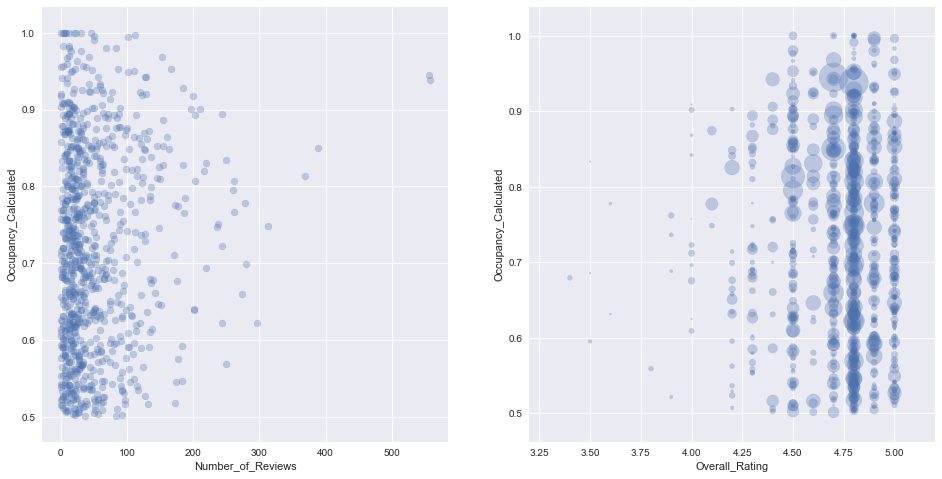

In [60]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].scatter(listing_data_df['Number_of_Reviews'], listing_data_df['Occupancy_Calculated'], 
              alpha=0.3)
ax[0].set_xlabel('Number_of_Reviews')
ax[0].set_ylabel('Occupancy_Calculated')
ax[1].scatter(listing_data_df['Overall_Rating'], listing_data_df['Occupancy_Calculated'],
              alpha=0.3, s=listing_data_df['Number_of_Reviews']*1.5)
ax[1].set_xlabel('Overall_Rating')
ax[1].set_ylabel('Occupancy_Calculated')
ax[1].set_xlim(3.2,5.2)


**Takeaways:**
- As expected, as Number_of_Reviews increases, the Occupancy Rate tends to increase
- As expected, as Overall_Rating increases, the Occupancy Rate tends to increase

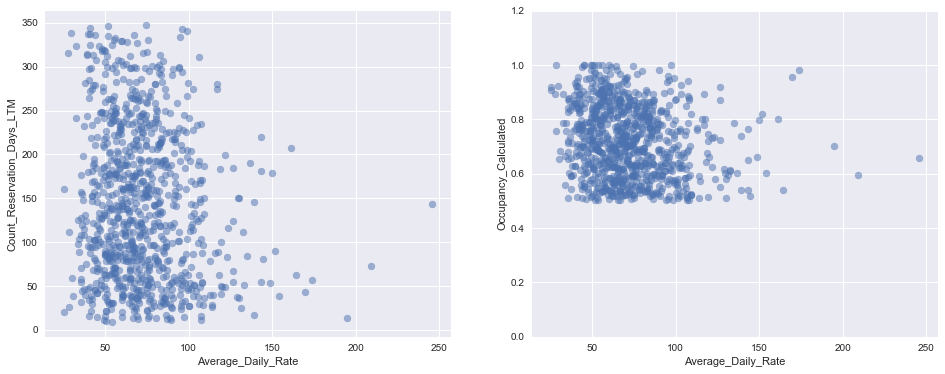

In [61]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Average_Daily_Rate'], listing_data_df['Count_Reservation_Days_LTM'], alpha=0.5)
ax[0].set_xlabel('Average_Daily_Rate')
ax[0].set_ylabel('Count_Reservation_Days_LTM')
ax[1].scatter(listing_data_df['Average_Daily_Rate'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[1].set_xlabel('Average_Daily_Rate')
ax[1].set_ylabel('Occupancy_Calculated')
ax[1].set_ylim(0,1.2)
plt.show()

**Takeaways:**
- As expected, negative correlation between ADR and Count_Reservation_Days_LTM
- As expected, negative correlation between ADR and Occupancy_calculated

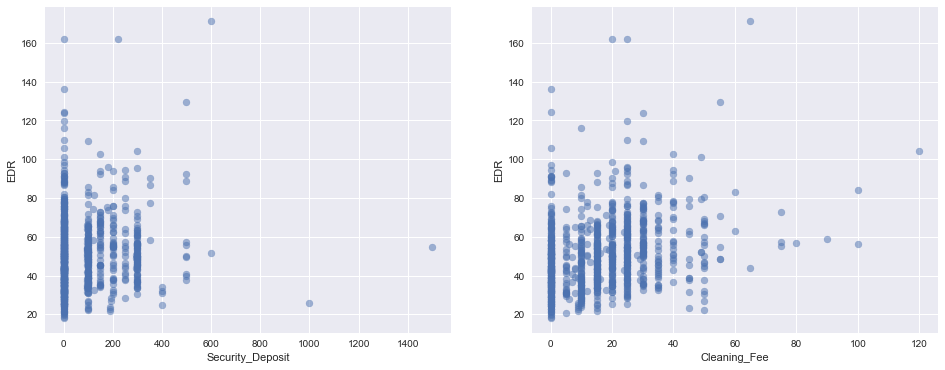

In [62]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Security_Deposit'], listing_data_df['EDR'], alpha=0.5)
ax[0].set_xlabel('Security_Deposit')
ax[0].set_ylabel('EDR')
ax[1].scatter(listing_data_df['Cleaning_Fee'], listing_data_df['EDR'], alpha=0.5)
ax[1].set_xlabel('Cleaning_Fee')
ax[1].set_ylabel('EDR')
#ax[1].set_ylim(0,1.2)
plt.show()

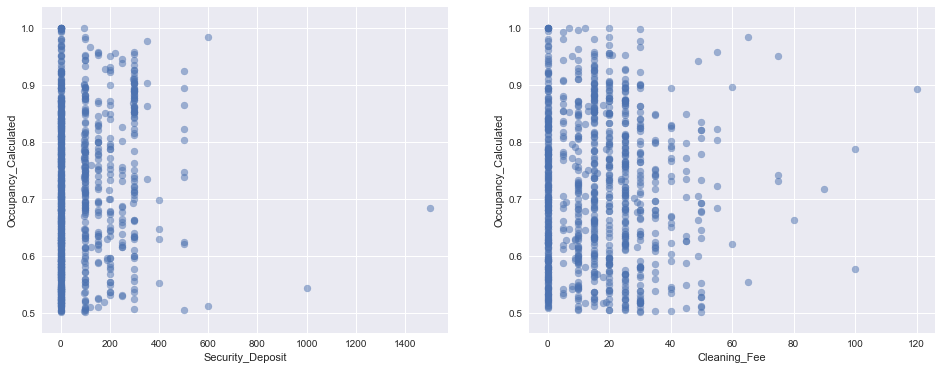

In [63]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(listing_data_df['Security_Deposit'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[0].set_xlabel('Security_Deposit')
ax[0].set_ylabel('Occupancy_Calculated')
ax[1].scatter(listing_data_df['Cleaning_Fee'], listing_data_df['Occupancy_Calculated'], alpha=0.5)
ax[1].set_xlabel('Cleaning_Fee')
ax[1].set_ylabel('Occupancy_Calculated')
#ax[1].set_ylim(0,1.2)
plt.show()

**Takeaways:**
- Occupancy_calculated largely independent of Security_Deposit and Cleaning_Fee

# Predictive Modeling (Annual)

In [64]:
listing_data_df.shape

(909, 55)

In [65]:
listing_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Listing_Title',                 u'Property_Type',
                        u'Listing_Type',                  u'Created_Date',
                   u'Last_Scraped_Date',                       u'Country',
                               u'State',                          u'City',
                        u'Neighborhood', u'Metropolitan_Statistical_Area',
                             u'Zipcode',            u'Average_Daily_Rate',
                  u'Annual_Revenue_LTM',            u'Occupancy_Rate_LTM',
                u'Occupancy_Calculated',        u'Number_of_Bookings_LTM',
                   u'Number_of_Reviews',                u'Overall_Rating',
                            u'Bedrooms',                     u'Bathrooms',
                          u'Max_Guests',         u'Calendar_Last_Updated',
                       u'Response_Rate',             u'Response_Time_min',
                         

In [66]:
listing_gdbr0_cols_keep = [
# ==== LISTING DETAILS ==========
#'Bathrooms', 'Bedrooms',
#'Days_Since_Created', 'Number_of_Photos','Instantbook_Enabled',
# ---- Exclude 
#'Property_ID', 'Listing_Title', 'Listing_Main_Image_URL','Listing_URL','Created_Date', 
#'Check-in_Time', 'Checkout_Time', 'Max_Guests', 'Minimum_Stay', 
    
# ==== BOOKING HISTORY =========
'EDR', 
# ---- Exclude 
#'Occupancy_Calculated', 'Annual_Revenue_LTM', 'Average_Daily_Rate' 'Last_Scraped_Date','Calendar_Last_Updated', 
#'Number_of_Bookings_LTM','Count_Blocked_Days_LTM', 'Count_Reservation_Days_LTM','Count_Available_Days_LTM',

# ==== LOCATION ================
'Latitude', 'Longitude',
# ---- Exclude 
#'Country', 'State','City', 'Metropolitan_Statistical_Area',    

# ==== EXTENDED STAY DETAILS ===
# --- -Exclude 
#'Published_Monthly_Rate','Published_Nightly_Rate', 'Published_Weekly_Rate', 
 
# ==== ADDITIONAL FEES =========
#'Security_Deposit', 'Extra_People_Fee', 'Cleaning_Fee', 

# ==== HOST QUALITY ============
#'Superhost', 'Overall_Rating','Number_of_Reviews',  
# ---- Exclude 
#'Response_Rate', 'Response_Time_min',

# ==== SPECIAL FEATURES ========
#'Pike_Market', 'nonroom', 'private_bath', 'view', 'water','parking', 
# ---- Exclude 
#',
]

listing_gdbr0_cols_dummy = [
#'Neighborhood',
#'Zipcode',
#'Cancellation_Policy',    
#'Property_Type'    
]

In [67]:
# train_ind, test_ind = get_loftium_train_test_split(df)
# X_train = X[train_ind]
# X_test = X[test_ind]
# y_train = y[train_ind]
# y_test = y[test_ind]

In [68]:
X = pred.prep_model_df(listing_data_df, listing_gdbr0_cols_keep, listing_gdbr0_cols_dummy)
X = X.drop('EDR', axis=1)
y = listing_data_df['EDR']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [69]:
gdbr0_model, gdbr0_pred_df, gdbr0_pred_test_df, \
gdbr0_X_train, gdbr0_X_test, gdbr0_y_train, gdbr0_y_test = pred.get_model_predictions_df(GradientBoostingRegressor(), 
                                                                                          listing_data_df, 'EDR', 
                                                                                          listing_gdbr0_cols_keep, listing_gdbr0_cols_dummy,
                                                                                          conf_interval=0.9,
                                                                                          loft_sample=False)

Running GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False) for label EDR
Splitting into 681 training instances
((681, 2), (228, 2))
Running cross validation...
CV MSE: 264.609287593, CV R2: 0.178930046025
Training model...
Test MSE: 319.718586734, Test R2: 0.190112689591
Returned pred df with shape (228,)


In [70]:
#pred.plot_partial_dependency_plots(gdbr0_model,gdbr0_train_df, 3,3,15)

In [71]:
gdbr0_model.predict(np.array((47.6084, -122.341)).reshape(1,-1))[0]

66.332390746738781

### Saving model gdbr0 as pickle - base model with only latitude and longitude

In [72]:
# with open('app/static/model_gdbr0.pkl', 'w') as f:
#     pickle.dump(gdbr0_model, f)

### GDBR Confidence Band Intervals

In [73]:
gdbr0_model_CI = gdbr0_model

alpha = 0.95
gdbr0_model_CI.set_params(alpha=alpha, loss='quantile')

gdbr0_model_CI.fit(gdbr0_X_train, gdbr0_y_train)

# Make the prediction on the meshed x-axis
y_lower = gdbr0_model_CI.predict(gdbr0_X_test)

In [74]:
gdbr0_model_CI.set_params(alpha=1.0 - alpha)

gdbr0_model_CI.fit(gdbr0_X_train, gdbr0_y_train)

# Make the prediction on the meshed x-axis
y_upper = gdbr0_model_CI.predict(gdbr0_X_test)

In [75]:
y_lower.shape, y_upper.shape, gdbr0_pred_df.pred.shape

((228,), (228,), (909,))

In [76]:
y_lower[:10], y_upper[:10], y_pred[:10]

NameError: name 'y_pred' is not defined

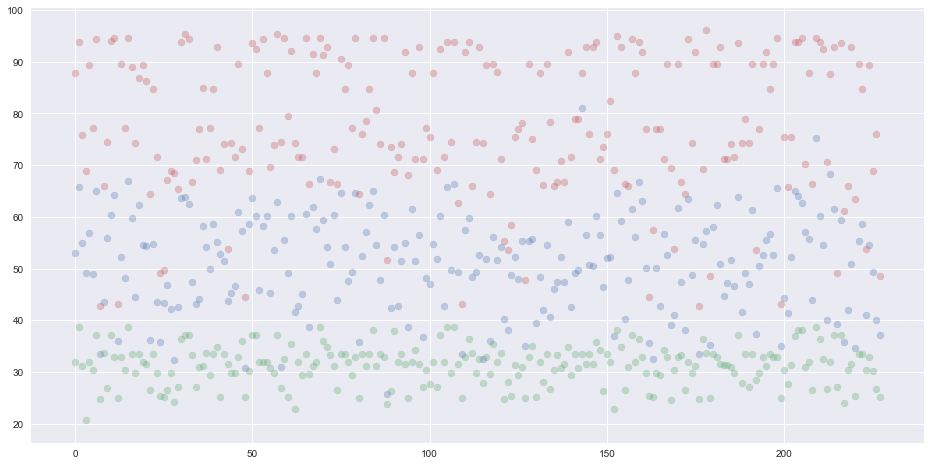

In [77]:
fig, ax = plt.subplots(1,figsize=(16,8))
x = range(gdbr0_pred_test_df.shape[0])
ax.scatter(x, gdbr0_pred_test_df, alpha=0.3)
ax.scatter(x, y_upper, alpha=0.3)
ax.scatter(x, y_lower, alpha=0.3)

## Class Testing

In [78]:
import src.airbnKEY_model as key
reload(key)

<module 'src.airbnKEY_model' from 'src/airbnKEY_model.pyc'>

In [79]:
cl_dummy_list = key.get_dummy_dfs(listing_data_df, listing_gdbr0_cols_dummy)
tmp_model_df = key.prep_model_df(listing_data_df, listing_gdbr0_cols_keep, cl_dummy_list)

In [85]:
X = tmp_model_df.drop('EDR', axis=1)
y = tmp_model_df.EDR
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [86]:
tmp_model = key.AirbnKEY_Model(GradientBoostingRegressor(), conf_interval=0.90)

In [87]:
tmp_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [88]:
tmp_model.cv_mse(cv_folds=5)

275.83530073873732

In [89]:
tmp_model.test_mse(X_test, y_test)

363.03725371437707

In [90]:
tmp_pred = tmp_model.predict(X_test)

In [91]:
tmp_lower, tmp_upper = tmp_model.predict_conf_interval(X_test, y_test)

In [92]:
tmp_lower[:10], tmp_pred[:10], tmp_upper[:10]

(array([ 39.69487121,  37.23266548,  39.97341562,  34.01912471,
         24.92788448,  36.12007536,  33.72885522,  24.99206639,
         34.66566632,  30.04681526]),
 array([ 58.70747742,  66.15907352,  63.11774105,  48.85416978,
         36.31040382,  58.45431925,  56.71572023,  33.96986431,
         48.14840983,  55.6789424 ]),
 array([ 91.77903233,  85.52838906,  92.80101729,  83.90804907,
         51.61687276,  92.91632252,  91.77903233,  67.56296453,
         76.26078933,  92.03719192]))

# GDBR Iteration 1

GDBR0 - Only Latitude and Longitude
GDBR1 - Adding in additional features

In [93]:
listing_gdbr1_cols_keep = [
# ==== LISTING DETAILS ==========a
#'Bathrooms', 'Bedrooms',
'Days_Since_Created', 'Number_of_Photos','Instantbook_Enabled',
'Max_Guests', 'Minimum_Stay', 
# ---- Exclude 
#'Property_ID', 'Listing_Title', 'Listing_Main_Image_URL','Listing_URL','Created_Date', 
#'Check-in_Time', 'Checkout_Time', 
    
# ==== BOOKING HISTORY =========
'EDR', 
# ---- Exclude 
#'Occupancy_Calculated', 'Annual_Revenue_LTM', 'Average_Daily_Rate' 'Last_Scraped_Date','Calendar_Last_Updated', 
#'Number_of_Bookings_LTM','Count_Blocked_Days_LTM', 'Count_Reservation_Days_LTM','Count_Available_Days_LTM',

# ==== LOCATION ================
'Latitude', 'Longitude',
# ---- Exclude 
#'Country', 'State','City', 'Metropolitan_Statistical_Area',    

# ==== EXTENDED STAY DETAILS ===
# --- -Exclude 
#'Published_Monthly_Rate','Published_Nightly_Rate', 'Published_Weekly_Rate', 
 
# ==== ADDITIONAL FEES =========
'Security_Deposit', 'Extra_People_Fee', 'Cleaning_Fee', 

# ==== HOST QUALITY ============
'Superhost', 'Overall_Rating','Number_of_Reviews',  
# ---- Exclude 
#'Response_Rate', 'Response_Time_min',

# ==== SPECIAL FEATURES ========
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water','parking',
# ---- Exclude 
#'walk',
]

listing_gdbr1_cols_dummy = [
#'Neighborhood',
#'Zipcode',
'Cancellation_Policy',    
'Property_Type'    
]

In [94]:
# train_ind, test_ind = get_loftium_train_test_split(df)
# X_train = X[train_ind]
# X_test = X[test_ind]
# y_train = y[train_ind]
# y_test = y[test_ind]

In [95]:
gdbr1_model, gdbr1_pred_df, gdbr1_pred_test_df, \
gdbr1_X_train, gdbr1_X_test, gdbr1_y_train, gdbr1_y_test = pred.get_model_predictions_df(GradientBoostingRegressor(), 
                                                                                         listing_data_df, 'EDR', 
                                                                                         listing_gdbr1_cols_keep, listing_gdbr1_cols_dummy,
                                                                                         conf_interval=0.9,
                                                                                         loft_sample=False)

Running GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False) for label EDR
Splitting into 681 training instances
((681, 29), (228, 29))
Running cross validation...
CV MSE: 190.891058949, CV R2: 0.381955981272
Training model...
Test MSE: 275.062583884, Test R2: 0.333654102271
Returned pred df with shape (228,)


## Using class

In [96]:
cl_dummy_list = key.get_dummy_dfs(listing_data_df, listing_gdbr1_cols_dummy)
tmp_model_df = key.prep_model_df(listing_data_df, listing_gdbr1_cols_keep, cl_dummy_list)

In [97]:
X = tmp_model_df.drop('EDR', axis=1)
y = tmp_model_df.EDR
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [98]:
tmp_model = key.AirbnKEY_Model(GradientBoostingRegressor(), conf_interval=0.90)

In [99]:
tmp_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [100]:
tmp_model.cv_mse(cv_folds=5)

228.67279469830601

In [101]:
tmp_model.test_mse(X_test, y_test)

250.30704503779054

In [102]:
tmp_pred = tmp_model.predict(X_test)
tmp_lower, tmp_upper = tmp_model.predict_conf_interval(X_test, y_test)
tmp_lower[:10], tmp_pred[:10], tmp_upper[:10]

(array([ 32.20763283,  29.47853772,  26.87797451,  34.80506872,
         34.53625401,  35.18006253,  30.51555185,  34.80628545,
         30.49558952,  27.27668056]),
 array([ 45.57344467,  37.21126445,  56.79014011,  63.14514085,
         59.16746758,  53.38650037,  36.30349237,  63.90310585,
         48.6056816 ,  52.26064638]),
 array([ 74.34278305,  69.16928077,  80.62551901,  75.83657133,
         75.34919795,  75.41108537,  70.50793548,  75.75396537,
         81.73769323,  78.53826443]))

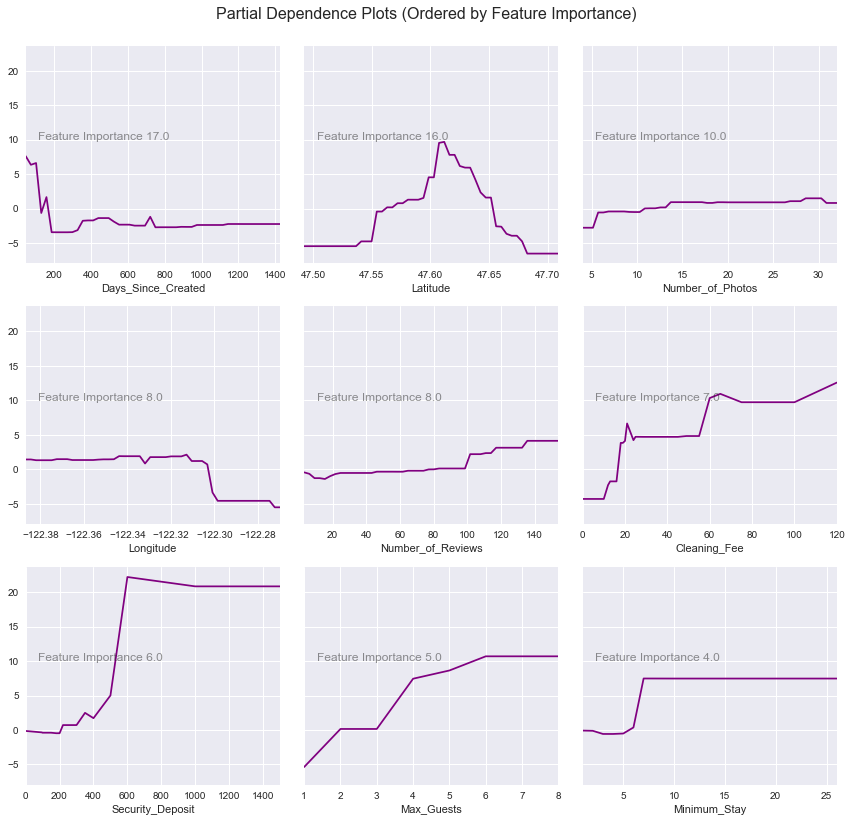

In [103]:
pred.plot_partial_dependency_plots(tmp_model.estimator,X_train, 3,3,10)

In [104]:
gdbr1_pred_X_df = pred.prep_model_df(listing_data_df, listing_gdbr1_cols_keep, pred.get_dummy_dfs(listing_data_df, listing_gdbr1_cols_dummy))

In [105]:
# Tuning by cross validation
N_ESTIMATORS = 4000
N_FOLDS = 10
X = gdbr1_pred_X_df.drop('EDR', axis=1)
y = gdbr1_pred_X_df['EDR']

train_scores = np.zeros((N_FOLDS, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_ESTIMATORS))

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

for k, (train_idxs, test_idxs) in enumerate(kf.split(X)):
    #print train_idxs
    X_train, y_train = X.iloc[train_idxs], y.iloc[train_idxs]
    X_test, y_test = X.iloc[test_idxs], y.iloc[test_idxs]
    model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
    model.fit(X_train, y_train)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_scores[k, i] = model.loss_(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_scores[k, i] = model.loss_(y_test, y_pred)
        
mean_train_score = np.mean(train_scores, axis=0)
mean_test_score = np.mean(test_scores, axis=0)

optimal_n_trees = np.argmin(mean_test_score)
optimal_score = mean_test_score[optimal_n_trees]
optimal_point = (optimal_n_trees, optimal_score)

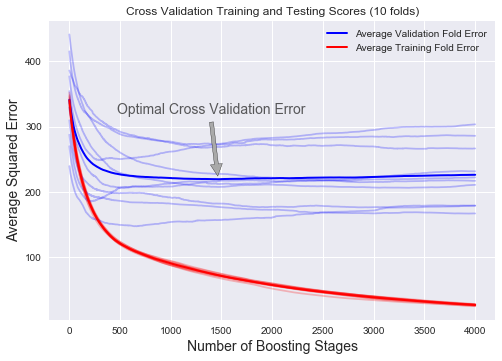

In [106]:
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, train_scores[i, :], color='red', alpha=0.25)
    
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, test_scores[i, :], color='blue', alpha=0.25)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_score, color='blue', linewidth=2,
         label='Average Validation Fold Error')
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_score, color='red', linewidth=2,
         label='Average Training Fold Error')

plt.annotate('Optimal Cross Validation Error', optimal_point,
              xytext=(optimal_point[0] - 1000, optimal_point[1] + 100),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )
plt.title("Cross Validation Training and Testing Scores (10 folds)")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")


## Grid Searching

In [107]:
grid_params = {'learning_rate': [ 0.001, 0.01, 0.1, 0.5, 1.0], 
               'max_features': ['sqrt', 'log2', None],
               'min_samples_leaf': [1,2,3,4],
               'max_depth':[1,2,5,10,20],
               'n_estimators': [100,500, 1000, 2000]
              }

In [108]:
gdbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                               grid_params,
                               n_jobs=-1,
                               verbose=True,
                               )

In [109]:
temp_dummy_list = pred.get_dummy_dfs(listing_data_df,listing_gdbr1_cols_dummy)
temp_df = pred.prep_model_df(listing_data_df, listing_gdbr1_cols_keep, temp_dummy_list)
X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('EDR', axis=1), temp_df.EDR)

In [110]:
gdbr_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 324 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 574 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 924 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1374 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1924 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 2574 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3324 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  5.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2', None], 'n_estimators': [100, 500, 1000, 2000], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0], 'max_depth': [1, 2, 5, 10, 20], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

In [111]:
gdbr_gridsearch.best_params_

{'learning_rate': 0.01,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [112]:
gdbr_gridsearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [113]:
gdbr_gridsearch_model, gdbr_gridsearch_pred_df, gdbr_gridsearch_pred_test_df, \
gdbr_gridsearch_X_train, gdbr_gridsearch_X_test, gdbr_gridsearch_y_train, \
gdbr_gridsearch_y_test = pred.get_model_predictions_df(gdbr_gridsearch.best_estimator_, 
                                                       listing_data_df, 'EDR', 
                                                       listing_gdbr1_cols_keep, listing_gdbr1_cols_dummy,
                                                       conf_interval=0.9,
                                                       loft_sample=False)

Running GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False) for label EDR
Splitting into 681 training instances
((681, 29), (228, 29))
Running cross validation...
CV MSE: 205.434067543, CV R2: 0.407012384067
Training model...
Test MSE: 209.803658531, Test R2: 0.366677935679
Returned pred df with shape (228,)


In [116]:
reload(pred)

<module 'src.airbnb_prediction_helper' from 'src/airbnb_prediction_helper.pyc'>

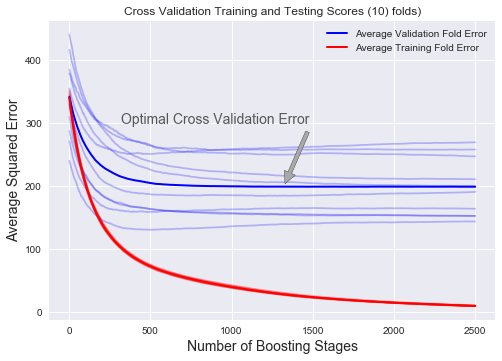

In [120]:
pred.plot_cross_validation_train_and_test(gdbr_gridsearch.best_estimator_, 
                                          gdbr1_pred_X_df.drop('EDR', axis=1), gdbr1_pred_X_df.EDR)

In [121]:
datestring = '{:04d}{:02d}{:02d}'.format(datetime.date.today().year, 
                                         datetime.date.today().month, 
                                         datetime.date.today().day,
                                         datetime.datetime.today().hour,
                                         datetime.datetime.today().minute,)
gdbr_gridsearch_pred_df.to_csv('data/gdbr_gridsearch_pred_results_OR50_annual_{}.csv'.format(datestring), sep=',', encoding='utf-8')

## Testing on class method

In [122]:
cl_dummy_list = key.get_dummy_dfs(listing_data_df, listing_gdbr1_cols_dummy)
tmp_model_df = key.prep_model_df(listing_data_df, listing_gdbr1_cols_keep, cl_dummy_list)

In [123]:
X = tmp_model_df.drop('EDR', axis=1)
y = tmp_model_df.EDR
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [124]:
tmp_model = key.AirbnKEY_Model(gdbr_gridsearch.best_estimator_, conf_interval=0.90)

In [125]:
tmp_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=5,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [126]:
tmp_model.cv_mse(cv_folds=5)

192.25618474913867

In [127]:
tmp_model.test_mse(X_test, y_test)

246.6302175973498

In [128]:
tmp_pred = tmp_model.predict(X_test)
tmp_lower, tmp_upper = tmp_model.predict_conf_interval(X_test, y_test)
tmp_lower[:10], tmp_pred[:10], tmp_upper[:10]

(array([ 39.35283917,  32.20157053,  32.34072241,  38.2620731 ,
         29.77508502,  35.24749484,  37.52171673,  33.34112484,
         39.86521765,  25.88781638]),
 array([ 81.22791383,  52.81559851,  42.36879623,  47.39001693,
         41.65455644,  48.12508861,  47.23552696,  45.88920326,
         72.73476701,  27.79640861]),
 array([ 98.40412462,  84.38313907,  62.3203454 ,  66.69330249,
         65.74782497,  65.48755854,  73.81162128,  64.96621872,
         72.19337586,  46.44299723]))

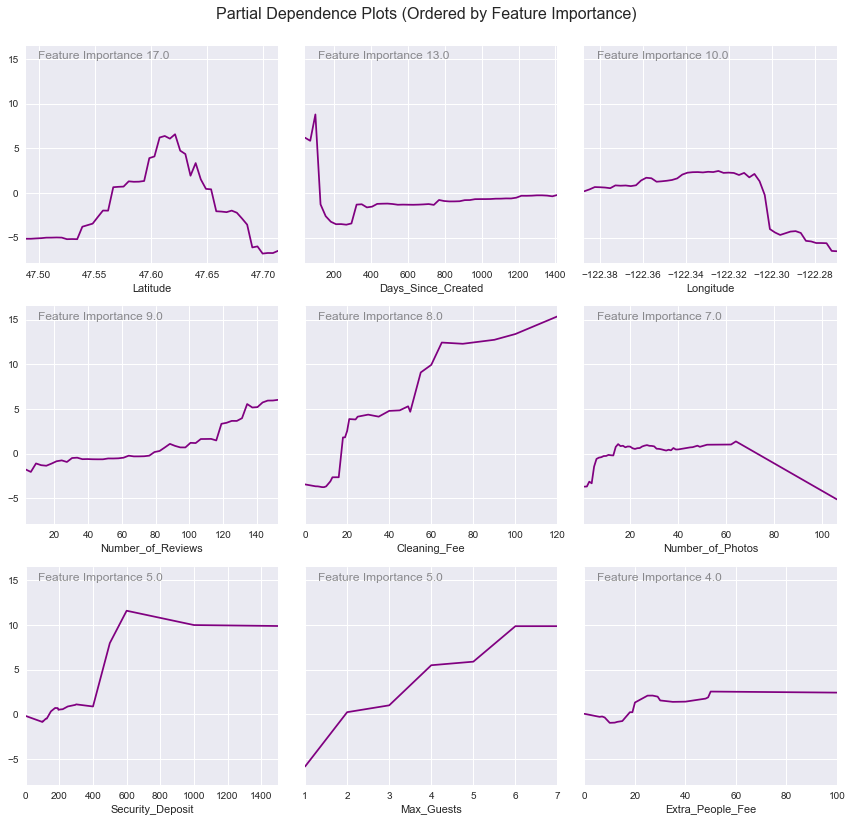

In [129]:
pred.plot_partial_dependency_plots(gdbr_gridsearch.best_estimator_,gdbr_gridsearch_X_train, 3,3,15)

In [111]:
# with open('app/static/model.pkl', 'w') as f:
#     pickle.dump(model_test, f)

## Generalized Linear Models

Gamma GLM

# Exploring the Monthly-level Data

In [357]:
monthly_data_df = monthly_data_raw_df.copy()

In [358]:
monthly_data_df.shape

(18595, 21)

In [359]:
#Only keeping properties with annual occupancy rates above 50%
prop_ids_to_keep = listing_data_df.Property_ID.unique()

In [360]:
monthly_data_df = monthly_data_df[monthly_data_df.Property_ID.isin(prop_ids_to_keep)]

In [361]:
monthly_data_df.shape

(9466, 21)

In [362]:
monthly_data_df['Property_Type'].replace('Bed &amp; Breakfast', 'Bed & Breakfast', inplace=True)
monthly_data_df['Month'] = monthly_data_df.Reporting_Month.apply(lambda x: x.month)
monthly_data_df['EDR'] = monthly_data_df.Occupancy_Rate * monthly_data_df.ADR

In [363]:
monthly_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR'],
      dtype='object')

In [364]:
monthly_data_df.sort_values(by='Reservation_Days', ascending=True)[[
       'Property_ID', 'Host_ID', 'Property_Type', 'Listing_Type', 'Bedrooms',
       'Occupancy_Rate', 'Revenue', 'ADR',
       'Number_of_Reservations', 'Reservation_Days', 'Available_Days',
       'Blocked_Days', 'Zip_code', 'Neighborhood',
       'Latitude', 'Longitude', 'Month',
       'EDR']].head(15)

,Property_ID,Host_ID,Property_Type,Listing_Type,Bedrooms,Occupancy_Rate,Revenue,ADR,Number_of_Reservations,Reservation_Days,Available_Days,Blocked_Days,Zip_code,Neighborhood,Latitude,Longitude,Month,EDR
13866,7724630,26877490.0,Apartment,Private room,1,1.000,70.00,70.00,1,1,0,30,98107,West Woodland,47.672717,-122.361417,7,70.00000
13333,7390195,38176125.0,Apartment,Private room,1,0.042,95.00,95.00,2,1,23,6,98199,Interbay,47.635773,-122.388619,9,3.99000
16534,10234558,31887689.0,Condominium,Private room,1,0.050,70.00,70.00,1,1,19,11,98107,Adams,47.670662,-122.378666,1,3.50000
2004,853112,4453873.0,House,Private room,1,1.000,110.00,110.00,2,1,0,30,98188,NaN,47.429987,-122.290957,8,110.00000
17957,13046519,8539387.0,Bed & Breakfast,Private room,1,0.045,81.17,81.17,1,1,21,9,98199,Lawton Park,47.649578,-122.393496,5,3.65265
2011,853112,4453873.0,House,Private room,1,1.000,85.00,85.00,1,1,0,30,98188,NaN,47.429987,-122.290957,7,85.00000
2023,853112,4453873.0,House,Private room,1,1.000,83.33,83.33,1,1,0,29,98188,NaN,47.429987,-122.290957,9,83.33000
16393,9878882,28011170.0,House,Private room,1,0.037,45.00,45.00,1,1,26,2,98125,Meadowbrook,47.712508,-122.294354,2,1.66500
2076,877203,287172.0,House,Private room,1,0.032,66.07,66.07,1,1,30,0,98144,Atlantic,47.600266,-122.299867,1,2.11424
16358,9823290,50596206.0,House,Private room,1,0.125,65.00,65.00,1,1,7,23,98144,Mount Baker,47.585650,-122.292887,3,8.12500


In [365]:
#Only keeping monthly data with reservation days > 10 days
monthly_data_df = monthly_data_df[monthly_data_df.Reservation_Days>10]

In [366]:
monthly_data_df.shape

(7418, 23)

### Let's see how prices vary by month (seasonality)

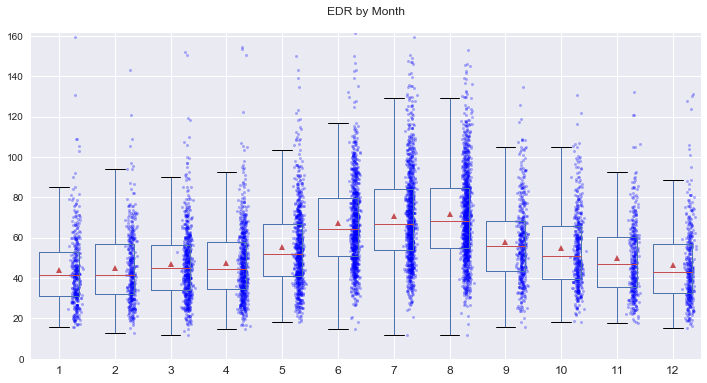

In [367]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='EDR', 
                       rot=0, fontsize=12, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=False)

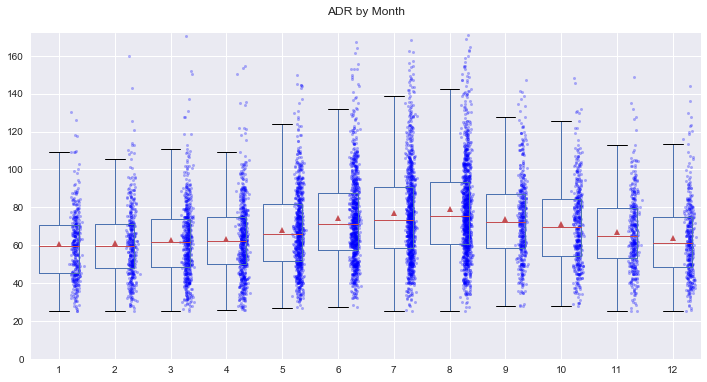

In [368]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='ADR', 
                       rot=0, fontsize=10, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=False)

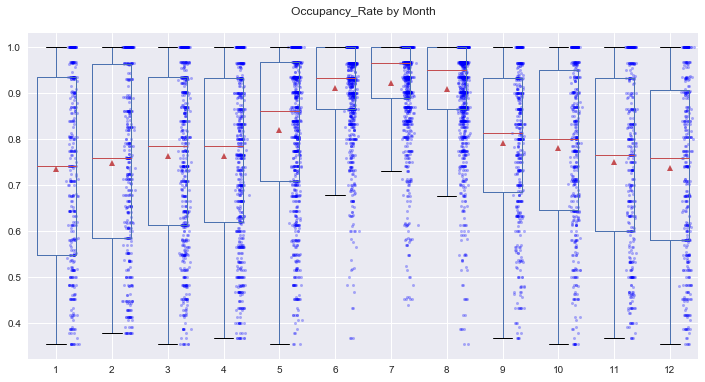

In [369]:
eda.plot_boxplot_sorted(monthly_data_df, 
                       by='Month', column='Occupancy_Rate', 
                       rot=0, fontsize=10, figsize=(12,6),sort_flag=False, jitter_offset=0.3, show_outliers=True)

**Takeaways:**
- ADRs and OccRate increase significantly during the summer periods
- **OccRate increases more than ADR during the summer**

### Which zipcodes exhibit the most seasonality?

In [370]:
monthly_data_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR'],
      dtype='object')

In [371]:
gb_month = monthly_data_df.groupby(['Zip_code','Month']).agg({'Occupancy_Rate': np.mean, 
                                                              'ADR':np.mean, 
                                                              'EDR':np.mean,
                                                              'Property_ID': len})

In [372]:
gb_monthly_var = gb_month['EDR'].reset_index().groupby('Zip_code').std()

top_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][:3]
bot_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][-3:]

top_and_bot_month_var = np.concatenate((np.array(top_month_var.index),
                                        np.array(bot_month_var.index)))

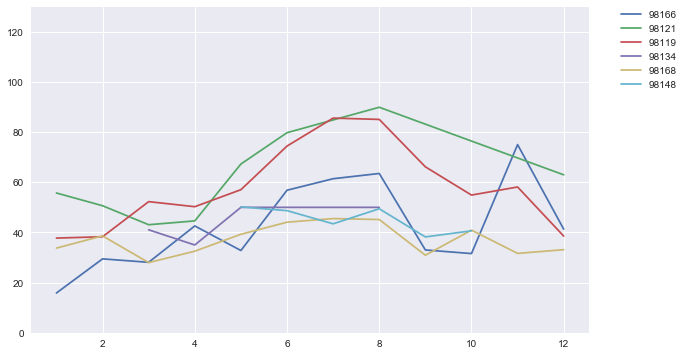

In [373]:
plt.figure(figsize=(10,6))

for item in top_and_bot_month_var:
    item_df = monthly_data_df[monthly_data_df.Zip_code==item]
    item_group_df = item_df.groupby('Month').mean()['EDR']
    
    plt.plot(item_group_df.index, item_group_df, label=item)

plt.ylim(0,130)
#plt.title('EDR by Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


**Takeaways**
- Top zipcodes exhibit significantly higher EDR during summer compared to bottom

In [374]:
gb_month = monthly_data_df.groupby(['Neighborhood','Month']).agg({'Occupancy_Rate': np.mean, 
                                                                  'ADR':np.mean, 
                                                                  'EDR':np.mean,
                                                                  'Property_ID': len
                                                                 })

In [375]:
gb_monthly_var = gb_month['EDR'].reset_index().groupby('Neighborhood').std()

top_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][:3]
bot_month_var = gb_monthly_var.sort_values('EDR', ascending=False)['EDR'][-3:]

top_and_bot_month_var = np.concatenate((np.array(top_month_var.index),
                                        np.array(bot_month_var.index)))

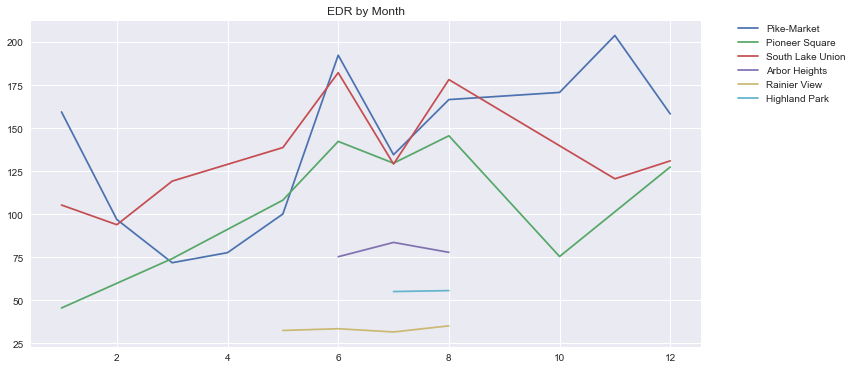

In [376]:
plt.figure(figsize=(12,6))

for item in top_and_bot_month_var:
    item_df = monthly_data_df[monthly_data_df.Neighborhood==item]
    item_group_df = item_df.groupby('Month').mean()['EDR']
    
    plt.plot(item_group_df.index, item_group_df, label=item)

plt.title('EDR by Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Analyzing Outliers

In [377]:
def remove_outliers(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    outlier_upper_limit = df[column].quantile(.75) + 1.5*(iqr)
    outlier_lower_limit = df[column].quantile(.25) - 1.5*(iqr)
    return df[(df[column] < outlier_upper_limit) & (df[column] > outlier_lower_limit)]

In [378]:
def get_outlier_ind(df, by):
    iqr = df[by].quantile(0.75) - df[by].quantile(0.25)
    outlier_upper_limit = df[by].quantile(.75) + 1.5*(iqr)
    outlier_lower_limit = df[by].quantile(.25) - 1.5*(iqr)
    #return df[(df[by] > outlier_upper_limit) | (df[by] < outlier_lower_limit)].index.values
    return df[(df[by] > outlier_upper_limit)].index.values

In [379]:
# Finding outliers per neighborhood
outliers_ind = []
for nhood in monthly_data_df.Neighborhood.unique():
    outliers_nhood_ind = get_outlier_ind(monthly_data_df[monthly_data_df.Neighborhood==nhood], 'EDR')
    #print (nhood, outliers_nhood_ind)
    for ind in outliers_nhood_ind:
        outliers_ind.append(ind)

In [380]:
monthly_data_outliers_df = monthly_data_df.loc[outliers_ind].sort_values('EDR', ascending=False)

# Predictive modeling (Monthly)

Let's reduce the features to only those that are relevant for predictive modeling, based on what we learned above.

## Gradient Boosting

We will be using gradient boosting due to the non-linear nature of key features, particularly latitude and longitude. 

Let's reduce features to only those relevant to a gradient boosting model.

In [381]:
monthly_gdbr_cols_keep = [
#'Property_ID',
#'Host_ID',
#'Listing_Type',
#'Bedrooms',
#'Reporting_Month',
#'Occupancy_Rate',
#'Revenue','ADR',
#'Number_of_Reservations','Reservation_Days','Available_Days','Blocked_Days',
#'Country','State','City','Metropolitan_Statistical_Area',
'Latitude','Longitude',
'EDR',
]

monthly_gdbr_cols_dummy =[
#'Zip_code',
#'Neighborhood',
'Month',
'Property_Type',
]

In [384]:
gdbr_monthly_model, gdbr_monthly_pred_df, gdbr_monthly_pred_test_df, \
gdbr_monthly_X_train, gdbr_monthly_X_test, gdbr_monthly_y_train, \
gdbr_monthly_y_test = pred.get_model_predictions_df(GradientBoostingRegressor(), 
                                                       monthly_data_df, 'EDR', 
                                                       monthly_gdbr_cols_keep, monthly_gdbr_cols_dummy,
                                                       conf_interval=0.9,
                                                       loft_sample=False)

Running GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False) for label EDR
Splitting into 5563 training instances
((5563, 21), (1855, 21))
Running cross validation...
CV MSE: 284.144656246, CV R2: 0.487556079834
Training model...
Test MSE: 367.213969491, Test R2: 0.432150956851
Returned pred df with shape (1855,)


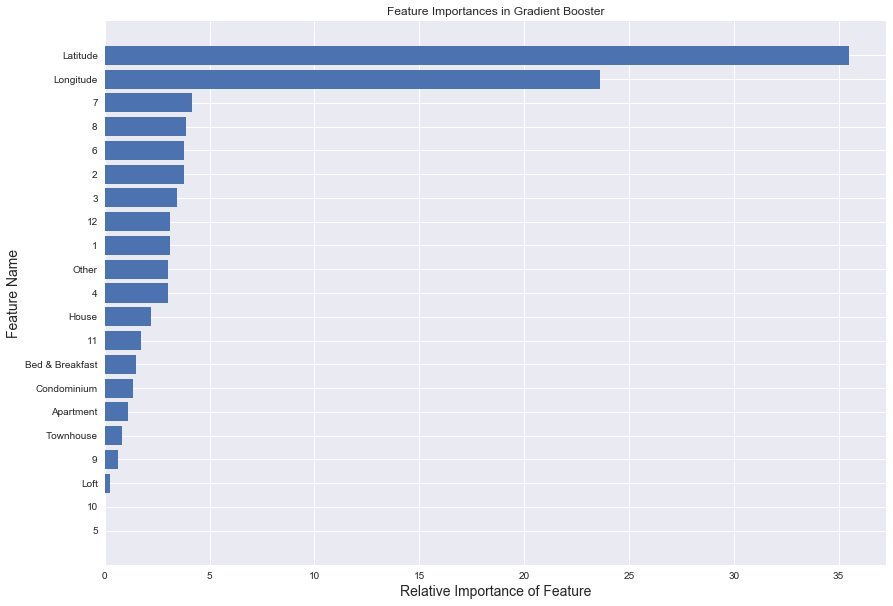

In [385]:
pred.plot_feature_importances(gdbr_monthly_model,gdbr_monthly_X_train)

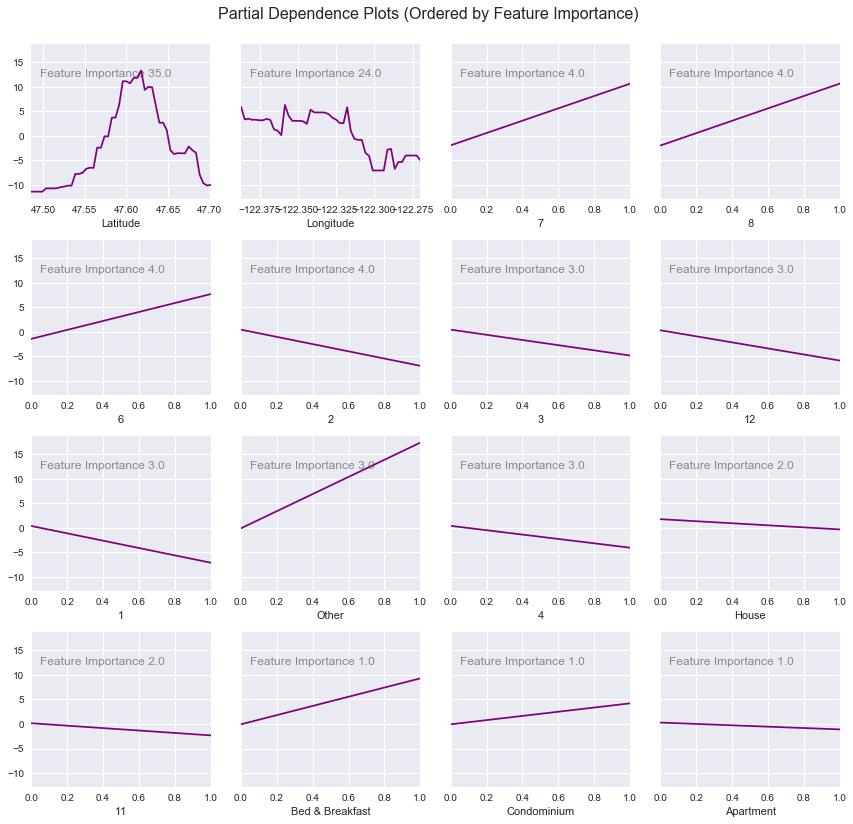

In [386]:
pred.plot_partial_dependency_plots(gdbr_monthly_model,gdbr_monthly_X_train, 4,4, 12)

In [197]:
#gdbr_monthly_pred_df.to_csv('predictions/gdbr_monthly_pred_results_random_sample_OR50_RD10.csv')
#gdbr_monthly_pred_df.to_csv('predictions/gdbr_monthly_pred_results_OR50_RD10_loft_sample.csv')

## Using class model

In [419]:
cl_dummy_list = key.get_dummy_dfs(monthly_data_df, monthly_gdbr_cols_dummy)
cl_monthly_model_df = key.prep_model_df(monthly_data_df, monthly_gdbr_cols_keep, cl_dummy_list)

In [420]:
X = cl_monthly_model_df.drop('EDR', axis=1)
y = cl_monthly_model_df.EDR
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [421]:
cl_gdbr_monthly_model = key.AirbnKEY_Model(GradientBoostingRegressor(), conf_interval=0.90)

In [422]:
cl_gdbr_monthly_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [423]:
cl_gdbr_monthly_model.cv_mse(cv_folds=5)

310.55201621055846

In [424]:
cl_gdbr_monthly_model.test_mse(X_test, y_test)

283.29199813936594

In [425]:
cl_gdbr_monthly_pred = cl_gdbr_monthly_model.predict(X_test)

In [426]:
cl_gdbr_monthly_lower, cl_gdbr_monthly_upper = cl_gdbr_monthly_model.predict_conf_interval(X_test, y_test)

In [427]:
cl_gdbr_monthly_lower[:10], cl_gdbr_monthly_pred[:10], cl_gdbr_monthly_upper[:10]

(array([ 31.06498777,  26.02513926,  35.02431778,  39.85729037,
         31.44794506,  34.51621168,  24.32188444,  28.02498728,
         33.65125169,  34.63618355]),
 array([ 53.67695812,  42.32697789,  58.21261713,  63.65996661,
         53.68929723,  54.35022618,  45.5964184 ,  64.17865001,
         67.71405626,  65.40613925]),
 array([  78.87192754,   76.43527818,   82.88701799,   90.17683401,
          85.76057269,   76.18169631,   74.00422554,   98.02604491,
         113.55646774,   97.81746558]))

In [428]:
with open('app/static/cl_gdbr_monthly_model.pkl', 'w') as f:
    pickle.dump(cl_gdbr_monthly_model, f)

## Creating and saving figure

In [475]:
input_data_base = np.array((lat, lng,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0)).reshape(1,-1)
input_data_list=[]
for i in range(12):
    month_input_data = np.copy(input_data_base)
    month_input_data[:,i+2]=1
    input_data_list.append(month_input_data)
    #print month_input_data

pred_list=[]
for input_data in input_data_list:
    pred = int(cl_gdbr_monthly_model.predict(input_data)[0])
    pred_list.append((pred))

In [506]:
from matplotlib.pyplot import savefig

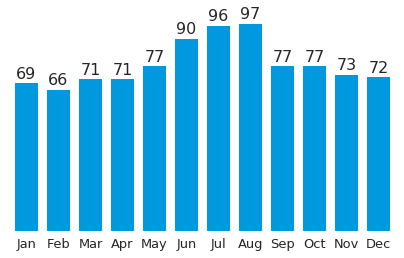

In [527]:
pred_series = pd.Series.from_array(pred_list)   # in my original code I create a series and run on that, so for consistency I create a series from the list.

cgfont = {'fontname':'Century Gothic'}
#hfont = {'fontname':'Helvetica'}

#plt.title('title',**csfont)


x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# now to plot the figure...
plt.figure(figsize=(7, 4))
ax = pred_series.plot(kind='bar', rot=0, grid=None, fontsize=13, color="#0099DF", width=0.7)
ax.set_xticklabels(x_labels,**cgfont)
#plt.xlabel(**cgfont)
ax.set_facecolor('white')
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

rects = ax.patches

# Now make some labels
labels = pred_list

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom', fontsize=16, **cgfont)
plt.yticks([])

savefig('monthly_income', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=True, bbox_inches=None, pad_inches=0.0,
        frameon=None)

## Adding additional features to monthly df

In [387]:
# Identifying columns from listing_data_df that we can add to monthly_data_df
#col_diff = 
np.setdiff1d(np.array(listing_data_df.columns),np.array(monthly_data_df.columns) )

array([u'Annual_Revenue_LTM', u'Average_Daily_Rate', u'Bathrooms',
       u'Calendar_Last_Updated', u'Cancellation_Policy', u'Checkin_Time',
       u'Checkout_Time', u'Cleaning_Fee', u'Count_Available_Days_LTM',
       u'Count_Blocked_Days_LTM', u'Count_Reservation_Days_LTM',
       u'Created_Date', 'Days_Since_Created', u'Extra_People_Fee',
       u'Instantbook_Enabled', u'Last_Scraped_Date',
       u'Listing_Main_Image_URL', u'Listing_Title', u'Listing_URL',
       u'Max_Guests', u'Minimum_Stay', u'Number_of_Bookings_LTM',
       u'Number_of_Photos', u'Number_of_Reviews', u'Occupancy_Calculated',
       u'Occupancy_Rate_LTM', u'Overall_Rating', 'Pike_Market',
       u'Published_Monthly_Rate', u'Published_Nightly_Rate',
       u'Published_Weekly_Rate', u'Response_Rate', u'Response_Time_min',
       u'Security_Deposit', u'Superhost', u'Zipcode', 'nonroom', 'parking',
       'private_bath', 'view', 'walk', 'water'], dtype=object)

In [388]:
listing_gdbr_cols_keep_merge = [
 'Property_ID',
 'Days_Since_Created',
 'Number_of_Photos',
 'Bathrooms',   
# 'Bedrooms',   # Already in monthly_df
 'Instantbook_Enabled',
# 'EDR',        # Already in monthly_df
# 'Latitude',   # Already in monthly_df
# 'Longitude',  # Already in monthly_df
 'Security_Deposit',
 'Extra_People_Fee',
 'Cleaning_Fee',
 'Superhost',
 'Overall_Rating',
 'Number_of_Reviews',
 'Pike_Market',
 'nonroom',
 'private_bath',
 'view',
 'water',
 'parking'
]

In [389]:
merge_df = pd.merge(monthly_data_df, 
                    listing_data_df[listing_gdbr_cols_keep_merge], 
                    left_on='Property_ID',  right_on='Property_ID', how='inner')

In [390]:
merge_df.shape

(7418, 39)

In [391]:
merge_df.head()

,Property_ID,Host_ID,Property_Type,Listing_Type,Bedrooms,Reporting_Month,Occupancy_Rate,Revenue,ADR,Number_of_Reservations,Reservation_Days,Available_Days,Blocked_Days,Country,State,City,Zip_code,Neighborhood,Metropolitan_Statistical_Area,Latitude,Longitude,Month,EDR,Days_Since_Created,Number_of_Photos,Bathrooms,Instantbook_Enabled,Security_Deposit,Extra_People_Fee,Cleaning_Fee,Superhost,Overall_Rating,Number_of_Reviews,Pike_Market,nonroom,private_bath,view,water,parking
0,9460,30832.0,Bed & Breakfast,Private room,1,2015-04-01,0.778,1559.0,74.24,6,21,6,3,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,4,57.75872,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
1,9460,30832.0,Bed & Breakfast,Private room,1,2016-04-01,0.733,2618.0,119.00,6,22,8,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,4,87.22700,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
2,9460,30832.0,Bed & Breakfast,Private room,1,2015-08-01,0.903,2832.0,101.14,8,28,3,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,8,91.32942,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
3,9460,30832.0,Bed & Breakfast,Private room,1,2016-08-01,0.839,3654.0,140.54,8,26,5,0,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,8,117.91306,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0
4,9460,30832.0,Bed & Breakfast,Private room,1,2014-12-01,0.769,1540.0,77.00,6,20,6,5,United States,Washington,Seattle,98104,First Hill,"Seattle-Tacoma-Bellevue, WA Metro Area",47.60801,-122.328739,12,59.21300,2558,11,1.0,1,0.0,15.0,0.0,1.0,4.9,279,0,0,0,0,0,0


In [392]:
merge_df.columns

Index([                  u'Property_ID',                       u'Host_ID',
                       u'Property_Type',                  u'Listing_Type',
                            u'Bedrooms',               u'Reporting_Month',
                      u'Occupancy_Rate',                       u'Revenue',
                                 u'ADR',        u'Number_of_Reservations',
                    u'Reservation_Days',                u'Available_Days',
                        u'Blocked_Days',                       u'Country',
                               u'State',                          u'City',
                            u'Zip_code',                  u'Neighborhood',
       u'Metropolitan_Statistical_Area',                      u'Latitude',
                           u'Longitude',                         u'Month',
                                 u'EDR',            u'Days_Since_Created',
                    u'Number_of_Photos',                     u'Bathrooms',
                 u'Instan

In [393]:
merge_gdbr_cols_keep = [
# ==== LISTING DETAILS ==========
# ---- Include    
'Days_Since_Created', 'Number_of_Photos',
#'Max_Guests', 'Minimum_Stay', 
#'Bathrooms', 'Bedrooms',
'Instantbook_Enabled',
# ---- Exclude 
#'Property_ID', 'Listing_Title', 'Listing_Main_Image_URL','Listing_URL','Created_Date', 
#'Check-in_Time', 'Checkout_Time', 
    
# ==== BOOKING HISTORY =========
# ---- Include
'EDR', 
# ---- Exclude 
#'Number_of_Bookings_LTM','Occupancy_Calculated', 'Last_Scraped_Date',
#'Count_Blocked_Days_LTM', 'Count_Reservation_Days_LTM','Count_Available_Days_LTM',
#'Annual_Revenue_LTM', 'Average_Daily_Rate'
#'Calendar_Last_Updated', 

# ==== LOCATION ================
# ---- Include
'Latitude', 'Longitude',
# ---- Exclude 
#'Country', 'State','City', 'Metropolitan_Statistical_Area',    

# ==== EXTENDED STAY DETAILS ===
# ---- Include
# --- -Exclude 
#'Published_Monthly_Rate','Published_Nightly_Rate', 'Published_Weekly_Rate', 
 
# ==== ADDITIONAL FEES =========
# ---- Include
'Security_Deposit', 'Extra_People_Fee', 'Cleaning_Fee', 

# ==== HOST QUALITY ============
# ---- Include
'Superhost', 'Overall_Rating','Number_of_Reviews',  
# ---- Exclude 
#'Response_Rate', 'Response_Time_min',

# ==== SPECIAL FEATURES ========
# ---- Include
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water','parking',
# ---- Exclude 
]

In [394]:
merge_gdbr_cols_dummy =[
#'Zip_code',
#'Neighborhood',
'Month',
'Property_Type',
]

In [395]:
gdbr_merge_model, gdbr_merge_pred_df, gdbr_merge_pred_test_df, \
gdbr_merge_X_train, gdbr_merge_X_test, gdbr_merge_y_train, \
gdbr_merge_y_test = pred.get_model_predictions_df(GradientBoostingRegressor(), 
                                                       merge_df, 'EDR', 
                                                       merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
                                                       conf_interval=0.9,
                                                       loft_sample=False)

Running GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False) for label EDR
Splitting into 5563 training instances
((5563, 36), (1855, 36))
Running cross validation...
CV MSE: 251.455697825, CV R2: 0.551888713082
Training model...
Test MSE: 262.354375478, Test R2: 0.579212385517
Returned pred df with shape (1855,)


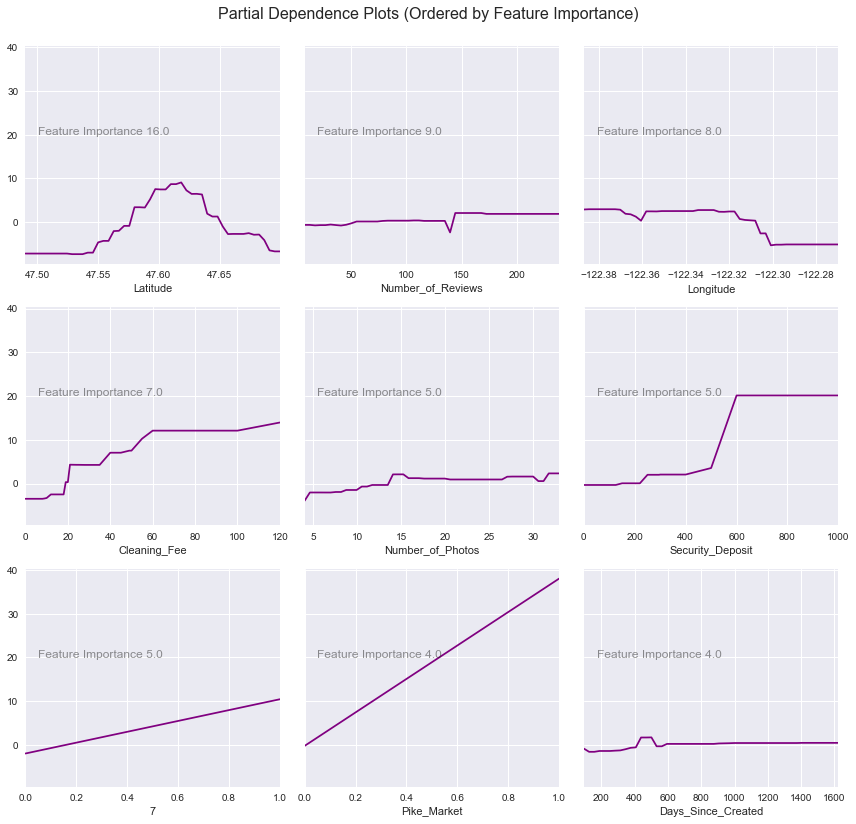

In [396]:
pred.plot_partial_dependency_plots(gdbr_merge_model,gdbr_merge_X_train)

In [213]:
#gdbr_merge_pred_df.to_csv('predictions/gdbr_monthly_pred_merge_results_core_loft_sample.csv')
gdbr_merge_pred_df.to_csv('predictions/gdbr_monthly_pred_merge_results_random_sample_OR50_RD10_2.csv')

## Using the class model

In [402]:
cl_dummy_list = key.get_dummy_dfs(merge_df, merge_gdbr_cols_dummy)
tmp_model_df = key.prep_model_df(merge_df, merge_gdbr_cols_keep, cl_dummy_list)

In [403]:
X = tmp_model_df.drop('EDR', axis=1)
y = tmp_model_df.EDR
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [404]:
tmp_model = key.AirbnKEY_Model(GradientBoostingRegressor(), conf_interval=0.90)

In [405]:
tmp_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [406]:
tmp_model.cv_mse(cv_folds=5)

254.60386468068754

In [407]:
tmp_model.test_mse(X_test, y_test)

245.5226638407928

In [408]:
tmp_pred = tmp_model.predict(X_test)
tmp_lower, tmp_upper = tmp_model.predict_conf_interval(X_test, y_test)
tmp_lower[:10], tmp_pred[:10], tmp_upper[:10]

(array([ 23.84970013,  34.51498052,  23.89126208,  35.03838804,
         31.55993904,  29.26205756,  35.1634858 ,  40.87800728,
         28.64560876,  44.32692158]),
 array([ 42.79981604,  78.72038438,  39.06894956,  68.65799836,
         62.87993536,  43.78108951,  63.5242397 ,  67.56609825,
         41.08079967,  92.1191345 ]),
 array([  69.27882251,   94.8266885 ,   72.18343548,   95.11757585,
          98.10806864,   79.31714135,   92.4098153 ,  100.47997032,
          59.96073017,  113.65029863]))

## Grid search on merge_df
Currently this is taking too long to run.  Use default for now.

In [397]:
# grid_params = {'learning_rate': [ 0.01, 0.1, 1.0], 
#                'max_features': ['sqrt', 'log2', None],
#                'min_samples_leaf': [1,2,3,4],
#                'max_depth':[1,2,5,10,20],
#                'n_estimators': [100,500, 1000, 2000]
#               }

In [398]:
# gdbr1_gridsearch = GridSearchCV(GradientBoostingRegressor(),
#                                grid_params,
#                                #n_jobs=-1,
#                                verbose=True,
#                                )

In [399]:
# temp_dummy_list = pred.get_dummy_dfs(merge_df,merge_gdbr_cols_dummy)
# temp_df = pred.prep_model_df(merge_df, merge_gdbr_cols_keep, temp_dummy_list)
# X_train, X_test, y_train, y_test = train_test_split(temp_df.drop('EDR', axis=1), temp_df.EDR)

In [400]:
#gdbr1_gridsearch.fit(X_train, y_train)

In [401]:
#gdbr1_gridsearch.best_params_

In [ ]:
#gdbr1_gridsearch.best_estimator_

In [ ]:
# gdbr1_merge_pred_df, gdbr1_merge_train_df, gdbr1_merge_model = pred.get_model_predictions_df(gdbr1_gridsearch.best_estimator_, 
#                                                                      merge_df, 'EDR', 
#                                                                      merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
#                                                                      loft_sample=False)

In [ ]:
# rf_merge_pred_df, rf_merge_model  = pred.get_model_predictions_df(RandomForestRegressor, 
#                                                  merge_df, 'EDR', 
#                                                  merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
#                                                    loft_sample=False)

In [ ]:
# lr_lasso_merge_pred_df, lr_lasso_merge_model  = pred.get_model_predictions_df(Lasso, 
#                                                        merge_df, 'EDR', 
#                                                        merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
#                                                    loft_sample=False)

In [ ]:
# lr_ridge_merge_pred_df, lr_ridge_gdbr_merge_model  = pred.get_model_predictions_df(Ridge, 
#                                                        merge_df, 'EDR', 
#                                                        merge_gdbr_cols_keep, merge_gdbr_cols_dummy,
#                                                    loft_sample=False)

### Conclusion: For predictive accuracy, Gradient Boosting consistently outperforms all other  models. 

### Stratifying samples by Zipcode

In [ ]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=0)

# for train_index, test_index in sss.split(gdbr_df,
#                                          gdbr_df['Zipcode']):
#     #print("TRAIN:", train_index, "TEST:", test_index)    
#     X_train = X.iloc[train_index]
#     X_test = X.iloc[test_index]
#     y_train = y.iloc[train_index]
#     y_test = y.iloc[test_index]

# print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
#listing_df.shape

In [ ]:
# #for neighborhood in listing_df.Neighborhood:
# def get_stratefied_samples(df, column, frac=0.7):
#     train_ind = []
#     test_ind = []
#     for neighborhood in listing_df.Neighborhood.unique():
#         nhood_ind = listing_df[listing_df.Neighborhood==neighborhood].index.values
#         nhood_train = np.random.choice(nhood_ind,  replace=False, size=len(nhood_ind)*frac)
#         nhood_test = np.setdiff1d(nhood_ind,nhood_train)
#         #nhood_ind.shape, nhood_train.shape, nhood_test.shape
#         for i in nhood_train:
#             train_ind.append(i)
#         for i in nhood_test:
#             test_ind.append(i)
#     return (train_ind), (test_ind)

In [ ]:
# train_ind, test_ind = get_stratefied_samples(listing_df, 'Neighborhood')

In [ ]:
# np.intersect1d(np.array(train_ind), np.array(test_ind)), len(train_ind), len(test_ind)

In [ ]:
# X_train = listings_gdbr_df.loc[train_ind].values
# X_test = listings_gdbr_df.loc[test_ind].values

# y_train = listing_df.loc[train_ind]['EDR'].values
# y_test = listing_df.loc[test_ind]['EDR'].values

In [ ]:
# -get_cv_score(GradientBoostingRegressor(), X_train, y_train, cv=5, scoring='neg_mean_squared_error'), \
# get_cv_score(GradientBoostingRegressor(), X_train, y_train, cv=5, scoring='r2')

In [ ]:
# gdbr = GradientBoostingRegressor()
# gdbr.fit(X_train, y_train)
# y_pred = gdbr.predict(X_test)
# mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

# Statistical Inference

In [ ]:
cols_corr_matrix = [
#'Property_ID', 'Host_ID', 'Property_Type', 'Listing_Type', 
'Bedrooms', 'Bathrooms',
#'Reporting_Month', 
'Occupancy_Rate', 'Revenue', 'ADR','EDR', 
'Number_of_Reservations', 'Reservation_Days', 'Available_Days', 'Blocked_Days',
#'Country', 'State', 'City', 'Zip_code', 'Neighborhood',
#'Metropolitan_Statistical_Area', 
'Latitude', 'Longitude', 'Month',
'Days_Since_Created', 'Number_of_Photos', 
'Security_Deposit', 'Extra_People_Fee','Cleaning_Fee',
'Superhost', 'Overall_Rating', 'Number_of_Reviews', 'Instantbook_Enabled', 
'Pike_Market', 'nonroom', 'private_bath', 'view', 'water'
]

In [ ]:
eda.plot_corr_matrix_heatmap(merge_df[cols_corr_matrix], annot=False)

In [ ]:
merge_df.columns

In [ ]:
X = merge_df[['Number_of_Reviews', 'Instantbook_Enabled','private_bath' ]]
y = merge_df.EDR
X = sm.add_constant(X)
sm_lr_Number_of_Reviews = sm.OLS(y,X).fit()
pred.get_linreg_summary_sm(sm_lr_Number_of_Reviews)